In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan, sqrt
from datetime import datetime, timedelta
from smoothing import performSmoothing, euclidianDistance

/Users/safefleet/Desktop/Bachelor Thesis/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import csv

def read_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        for line_num, row in enumerate(file):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [34]:
file_path_skillcorner = '../data/matches/vs FC Lugano/2023-12-06_StatsPerform_FC Lugano - FC fifa format Basel.txt'
lineup_path = '../data/matches/vs FC Lugano/2023-12-06_StatsPerform_FC Lugano - FC Basel_Match-Info.csv'
partialframes = read_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetID = 402048
targetPositionsSkillcorner = []

def getTrajectories(teamID, lineup, partialframes):
    playerIDs = set()

    for player in list(filter(lambda player: int(player[1]) == 1, lineup)):
        playerIDs.add(str(player[9]))
    
    # print(playerIDs)
    # return None
    targetTrajs = {}
    for ID in playerIDs:
        targetTrajs[ID] = []

    for index, frame in enumerate(partialframes):
        f = re.split(':', frame)
        frameVars = re.split(';|,', f[0]) # 0 - system time; 1 - milliseconds of current half; 2 - current half
        frameVars = list(map(lambda x: int(x), frameVars))
        # print(frameVars)
        # return 
        playerPositions = f[1].split(';')
        for playerString in playerPositions:
            playerFrame = playerString.split(',') # 0 - object type; 1 - playerID; 2 - shirt Number, 3 - x; 4 - y
            if(len(playerFrame)) < 5:
                continue
            if(playerFrame[1] not in playerIDs):
                continue
            if targetTrajs[playerFrame[1]] == [] or int(targetTrajs[playerFrame[1]][-1][-1][-2]) != (int(frameVars[1]) - 40):
                targetTrajs[playerFrame[1]].append([])
            targetTrajs[playerFrame[1]][-1].append([float(playerFrame[3]), float(playerFrame[4]), -1, datetime.fromtimestamp(int(frameVars[1])/1000.0), int(frameVars[0]), int(frameVars[1]), int(frameVars[2])])
    return targetTrajs

targetTrajs = getTrajectories(1, lineup, partialframes)

In [36]:
print(len(targetTrajs['402048'][0]))

69223


In [59]:
# add for loop that starts here and smootens every trajectory in the traj list
targetedPlayerID = 402048

its = [
    0, 
    2,
    5, 
    10, 
    50, 
    # 100, 
    # 150, 
    # 200
]

def extractSmoothDataFrames(targetTrajs, targetedPlayerID, its, freq=25):
    smoothDataFrames = []
    for it in its:
        playerSmoothDataFrames = pd.DataFrame()

        for player, trajs in targetTrajs.items():

            if player != str(targetedPlayerID):
                continue
            
            if player == []:
                continue

            for traj in trajs:
                if(len(traj) < 2):
                    continue

                new_traj = performSmoothing(datapoints=traj, iterations=it)
                new_traj = pd.DataFrame(new_traj)
                new_traj[5] = player
                traj = pd.DataFrame(traj)
                for idx, row in traj.iterrows():
                    if(isnan(row[4])):
                        print('nan')

                new_traj[4] = traj[4]
                new_traj[7] = traj[6]
                new_traj[6] = traj[5]

                playerSmoothDataFrames = pd.concat([playerSmoothDataFrames, new_traj], axis=0, ignore_index=True)
        
        playerSmoothDataFrames[4] = playerSmoothDataFrames[4].astype(int)
        playerSmoothDataFrames.columns = ['x', 'y', 'arc_length', 'time', 'systemTime', 'object_id', 'timestamp', 'half']

        playerSmoothDataFrames['speed'] = playerSmoothDataFrames['arc_length']*freq
        playerSmoothDataFrames.loc[playerSmoothDataFrames['arc_length'] == -1, 'speed'] = None

        playerSmoothDataFrames['systemTime'] = playerSmoothDataFrames['systemTime'].astype(int)
        playerSmoothDataFrames['timestamp'] = playerSmoothDataFrames['timestamp'].astype(int)
        playerSmoothDataFrames['half'] = playerSmoothDataFrames['half'].astype(int)
        playerSmoothDataFrames['x'] = playerSmoothDataFrames['x'].astype(float)
        playerSmoothDataFrames['y'] = playerSmoothDataFrames['y'].astype(float)

        smoothDataFrames.append(playerSmoothDataFrames.copy())
    return smoothDataFrames
    
smoothDataFrames = extractSmoothDataFrames(targetTrajs, targetedPlayerID, its)
originalDF = smoothDataFrames[0].drop(columns=['arc_length'])
smoothDataFrames.pop(0)
smoothDataFrames[0]

,x,y,arc_length,time,systemTime,object_id,timestamp,half,speed
0,66.754000,31.484000,-1.000000,1970-01-01 02:00:00.000,1701894600000,402048,0,1,NaN
1,66.794079,31.420675,0.075048,1970-01-01 02:00:00.040,1701894600040,402048,40,1,1.876211
2,66.833963,31.356875,0.075433,1970-01-01 02:00:00.080,1701894600080,402048,80,1,1.885824
3,66.874203,31.292851,0.075807,1970-01-01 02:00:00.120,1701894600120,402048,120,1,1.895163
4,66.915239,31.228850,0.076247,1970-01-01 02:00:00.160,1701894600160,402048,160,1,1.906183
...,...,...,...,...,...,...,...,...,...
144396,18.244971,36.741769,0.092775,1970-01-01 02:50:06.920,1701901206920,402048,3006920,2,2.319385
144397,18.296092,36.819315,0.092985,1970-01-01 02:50:06.960,1701901206960,402048,3006960,2,2.324616
144398,18.347129,36.897291,0.093403,1970-01-01 02:50:07.000,1701901207000,402048,3007000,2,2.335077
144399,18.398004,36.975685,0.093507,1970-01-01 02:50:07.040,1701901207040,402048,3007040,2,2.337686


In [60]:
def extractMetrics(playerDF):
    maxSpeed = 0
    distanceCovered = 0
    metrics = {
        'maxSpeed': playerDF['speed'].max(),
        'distanceCovered': 0,
        'maximumSpeedSustained': 0,
        'sprintCount': 0,
    }

    # get sustained speed
    idxmax = playerDF['speed'].idxmax()
    l = idxmax
    h = l
    while (h < len(playerDF) and l >= 0):
        if(abs(playerDF.loc[h, 'speed'] - metrics['maxSpeed']) < 0.75):
            h += 1
        elif(abs(playerDF.loc[l, 'speed'] - metrics['maxSpeed']) < 0.75):
            l -= 1
        else:
            break
    metrics['maximumSpeedSustained'] = playerDF.loc[h, 'timestamp'] - playerDF.loc[l, 'timestamp']
    startOfSprintIDX = -1
    # handle unsmoothed data
    if("arc_length" not in playerDF.columns):
        for i, row in playerDF.iterrows():
            if(i == 0):
                continue
            if(row['timestamp'] == playerDF.loc[i-1, 'timestamp'] + 40):
                distanceCovered += euclidianDistance([row['x'], row['y']], [playerDF.loc[i-1, 'x'], playerDF.loc[i-1, 'y']])

            if(row['speed'] > 6.94):
                if(startOfSprintIDX == -1):
                    startOfSprintIDX = i
            else:
                if(startOfSprintIDX != -1):
                    timeOfSprint = playerDF.loc[i-1, 'timestamp'] - playerDF.loc[startOfSprintIDX, 'timestamp']
                    if(timeOfSprint > 700):
                        metrics['sprintCount'] += 1
                    startOfSprintIDX = -1
            
    # handle smoothened data
    else:
        for i, row in playerDF.iterrows():
            if(i == 0):
                continue
            arclength = row['arc_length']
            prevArclength = playerDF.loc[i-1, 'arc_length']
            if(arclength == -1 and prevArclength == -1):
                continue
            if((arclength != -1 and prevArclength == -1) or (arclength == -1 and prevArclength != -1)):
                distanceCovered += euclidianDistance([row['x'], row['y']], [playerDF.loc[i-1, 'x'], playerDF.loc[i-1, 'y']])
            else:
                distanceCovered += arclength/2 + prevArclength/2

            if(row['speed'] > 6.94):
                if(startOfSprintIDX == -1):
                    startOfSprintIDX = i
            else:
                if(startOfSprintIDX != -1):
                    timeOfSprint = playerDF.loc[i-1, 'timestamp'] - playerDF.loc[startOfSprintIDX, 'timestamp']
                    if(timeOfSprint > 700):
                        metrics['sprintCount'] += 1
                    startOfSprintIDX = -1
            
                
    metrics['distanceCovered'] = distanceCovered   
    return metrics

In [61]:

originaltargetedPlayerDF = pd.DataFrame(originalDF[originalDF['object_id'] == str(targetedPlayerID)])
# originaltargetedPlayerDF = pd.merge(originaltargetedPlayerDF, frames, how='right', on=['frame_id'])

# originaltargetedPlayerDF['arc_length'] = np.nan 
originaltargetedPlayerDF['x'] = originaltargetedPlayerDF['x'].astype(float)
originaltargetedPlayerDF['y'] = originaltargetedPlayerDF['y'].astype(float)
originaltargetedPlayerDF['timestamp'] = originaltargetedPlayerDF['timestamp'].astype(int)

euclidean_distance1 = np.sqrt((originaltargetedPlayerDF['x'] - originaltargetedPlayerDF['x'].shift(1))**2 + (originaltargetedPlayerDF['y'] - originaltargetedPlayerDF['y'].shift(1))**2)
euclidean_distance2 = np.sqrt((originaltargetedPlayerDF['x'] - originaltargetedPlayerDF['x'].shift(-1))**2 + (originaltargetedPlayerDF['y'] - originaltargetedPlayerDF['y'].shift(-1))**2)

timediff1 = originaltargetedPlayerDF['timestamp'] - originaltargetedPlayerDF['timestamp'].shift(1)
timediff2 = originaltargetedPlayerDF['timestamp'].shift(-1) - originaltargetedPlayerDF['timestamp']

originaltargetedPlayerDF['speed'] = (euclidean_distance1+euclidean_distance2)/(timediff1+timediff2)*1000

# Use the Series to fill the NaNs
# originaltargetedPlayerDF['arc_length'] = originaltargetedPlayerDF['arc_length'].fillna((euclidean_distance1 + euclidean_distance2)/2)

# originaltargetedPlayerDF['distance_covered'] = originaltargetedPlayerDF['arc_length'].cumsum() - euclidean_distance2/2
# originaltargetedPlayerDF['distance_covered'] = originaltargetedPlayerDF['arc_length'].cumsum()

originaltargetedPlayerDF['timediff'] = (originaltargetedPlayerDF['timestamp'] - originaltargetedPlayerDF['timestamp'].shift(1)) + (originaltargetedPlayerDF['timestamp'].shift(-1) - originaltargetedPlayerDF['timestamp'])
# if timediff is larger than 200, put speed to NaN
originaltargetedPlayerDF.loc[originaltargetedPlayerDF['timediff'] > 80, 'speed'] = np.nan

print(extractMetrics(originaltargetedPlayerDF))
originaltargetedPlayerDF

{'maxSpeed': 8.001366475811572, 'distanceCovered': 10125.96637122171, 'maximumSpeedSustained': 1160, 'sprintCount': 10}


,x,y,time,systemTime,object_id,timestamp,half,speed,timediff
0,66.754,31.484,1970-01-01 02:00:00.000,1701894600000,402048,0,1,NaN,NaN
1,66.794,31.421,1970-01-01 02:00:00.040,1701894600040,402048,40,1,1.876220,80.0
2,66.834,31.357,1970-01-01 02:00:00.080,1701894600080,402048,80,1,1.886796,80.0
3,66.874,31.293,1970-01-01 02:00:00.120,1701894600120,402048,120,1,1.893480,80.0
4,66.915,31.229,1970-01-01 02:00:00.160,1701894600160,402048,160,1,1.906965,80.0
...,...,...,...,...,...,...,...,...,...
144396,18.245,36.742,1970-01-01 02:50:06.920,1701901206920,402048,3006920,2,2.319392,80.0
144397,18.296,36.819,1970-01-01 02:50:06.960,1701901206960,402048,3006960,2,2.319392,80.0
144398,18.347,36.897,1970-01-01 02:50:07.000,1701901207000,402048,3007000,2,2.340316,80.0
144399,18.398,36.976,1970-01-01 02:50:07.040,1701901207040,402048,3007040,2,2.340316,80.0


In [62]:

print(extractMetrics(smoothDataFrames[0]))
smoothDataFrames[0]

{'maxSpeed': 7.9953883443391245, 'distanceCovered': 10125.776450062775, 'maximumSpeedSustained': 1160, 'sprintCount': 10}


,x,y,arc_length,time,systemTime,object_id,timestamp,half,speed
0,66.754000,31.484000,-1.000000,1970-01-01 02:00:00.000,1701894600000,402048,0,1,NaN
1,66.794079,31.420675,0.075048,1970-01-01 02:00:00.040,1701894600040,402048,40,1,1.876211
2,66.833963,31.356875,0.075433,1970-01-01 02:00:00.080,1701894600080,402048,80,1,1.885824
3,66.874203,31.292851,0.075807,1970-01-01 02:00:00.120,1701894600120,402048,120,1,1.895163
4,66.915239,31.228850,0.076247,1970-01-01 02:00:00.160,1701894600160,402048,160,1,1.906183
...,...,...,...,...,...,...,...,...,...
144396,18.244971,36.741769,0.092775,1970-01-01 02:50:06.920,1701901206920,402048,3006920,2,2.319385
144397,18.296092,36.819315,0.092985,1970-01-01 02:50:06.960,1701901206960,402048,3006960,2,2.324616
144398,18.347129,36.897291,0.093403,1970-01-01 02:50:07.000,1701901207000,402048,3007000,2,2.335077
144399,18.398004,36.975685,0.093507,1970-01-01 02:50:07.040,1701901207040,402048,3007040,2,2.337686


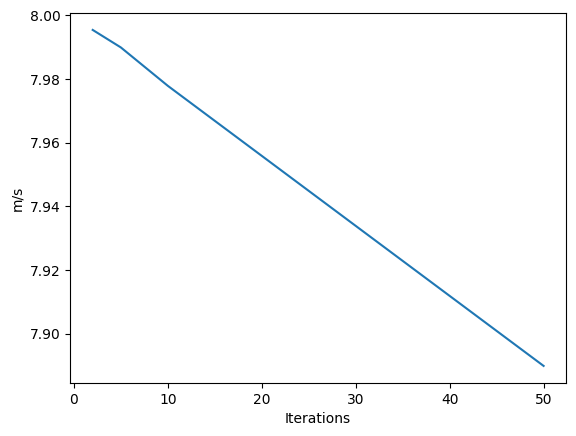

,iterations,maxSpeed,maximumSpeedSustained,sprintCount,distanceCovered
0,2,7.995388,1160,10,10125.776450
1,5,7.989882,1160,10,10125.444374
2,10,7.977826,1240,10,10125.000343
3,50,7.889877,1320,9,10121.655321


In [68]:
metrics = []
for df in smoothDataFrames:
    metrics.append(extractMetrics(df))
    
maxSpeedList = list(map(lambda m: m['maxSpeed'], metrics))
plt.plot(its[1:], maxSpeedList, label='Cumulated Maximum Speed of trajectories')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Max Speed [m/s]')  # Replace 'Value' with the actual y-axis label  
plt.show()
metrics = pd.DataFrame(metrics)
metrics['iterations'] = its[1:]
metrics = metrics[['iterations', 'maxSpeed', 'maximumSpeedSustained', 'sprintCount', 'distanceCovered']]
metrics